In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample

In [2]:
df = pd.read_csv("/kaggle/input/emotions-in-text/Emotion_final.csv")

<AxesSubplot:xlabel='Emotion', ylabel='count'>

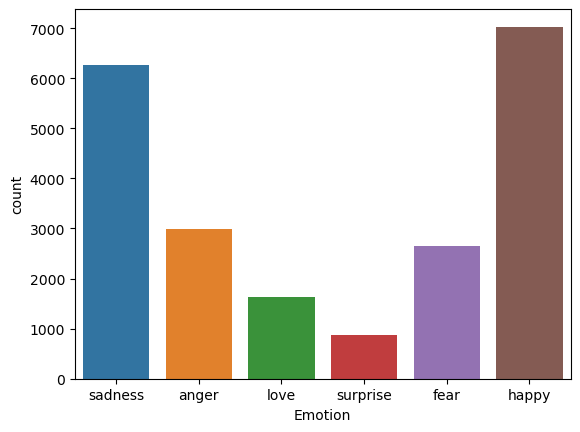

In [3]:
sns.countplot(x = "Emotion", data = df)

In [4]:
# upsample surprise
n_surp_sample = 1000
surp = df[df["Emotion"] == "surprise"]
surp_upsample = resample(surp, random_state = 35, n_samples=n_surp_sample, replace = True)

# upsample love
n_love_sample = 500
love = df[df["Emotion"] == "love"]
love_upsample = resample(love, random_state = 35, n_samples=n_love_sample, replace = True)

df = pd.concat([df, surp_upsample, love_upsample])

<AxesSubplot:xlabel='Emotion', ylabel='count'>

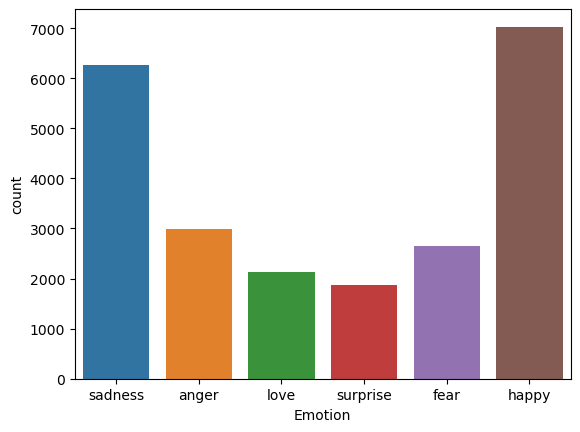

In [5]:
sns.countplot(x = "Emotion", data = df)

In [6]:
encoder = OneHotEncoder()
X = np.array(df.Text)
y = encoder.fit_transform(np.array(df.Emotion).reshape(-1,1)).toarray()

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train)

In [8]:
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as tf_hub
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model

In [9]:
def buil_model_with_bert():
    text_input = Input(shape=(), dtype=tf.string, name="text_input")
    
    preprocessor = tf_hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name="preprocessor")
    encoder_inputs = preprocessor(text_input)
    
    encoder = tf_hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/2", trainable=True, name="encoder")
    outputs = encoder(encoder_inputs)
    pooled_output = outputs["pooled_output"]
    
    net = Dense(512, activation="relu")(pooled_output)
    net = BatchNormalization()(net)
    net = Dropout(0.1)(net)
    net = Dense(128, activation="relu")(net)
    net = BatchNormalization()(net)
    net = Dropout(0.1)(net)
    net = Dense(units=6, activation='softmax')(net)
    
    return Model(inputs=text_input, outputs=net)

model = buil_model_with_bert()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 preprocessor (KerasLayer)      {'input_word_ids':   0           ['text_input[0][0]']             
                                (None, 128),                                                      
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [10]:
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("/kaggle/working/model.pth", monitor='val_accuracy', verbose=0, save_best_only=True, mode='auto')
t = time.time()
his = model.fit(x=X_train, y=y_train, batch_size=512, epochs=20, validation_data=(X_val, y_val), callbacks=[checkpoint])
print(f'Time taken: {time.time() - t}')

Epoch 1/20
37/37 [==============================] - 395s 10s/step - loss: 1.1665 - accuracy: 0.5951 - val_loss: 1.0730 - val_accuracy: 0.7576
Epoch 2/20
37/37 [==============================] - 377s 10s/step - loss: 0.3386 - accuracy: 0.8860 - val_loss: 0.6000 - val_accuracy: 0.8645
Epoch 3/20
37/37 [==============================] - 380s 10s/step - loss: 0.1967 - accuracy: 0.9260 - val_loss: 0.3813 - val_accuracy: 0.8868
Epoch 4/20
37/37 [==============================] - 376s 10s/step - loss: 0.1395 - accuracy: 0.9425 - val_loss: 0.2578 - val_accuracy: 0.9047
Epoch 5/20
37/37 [==============================] - 377s 10s/step - loss: 0.1111 - accuracy: 0.9563 - val_loss: 0.2399 - val_accuracy: 0.9115
Epoch 6/20
37/37 [==============================] - 375s 10s/step - loss: 0.0878 - accuracy: 0.9663 - val_loss: 0.2309 - val_accuracy: 0.9149
Epoch 7/20
37/37 [==============================] - 368s 10s/step - loss: 0.0669 - accuracy: 0.9745 - val_loss: 0.2418 - val_accuracy: 0.9226
Epoch 

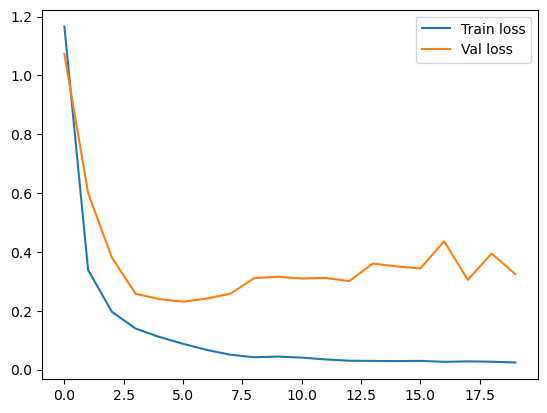

In [12]:
import matplotlib.pyplot as plt
plt.plot(his.history['loss'], label="Train loss")
plt.plot(his.history['val_loss'], label="Val loss")
plt.legend();

In [13]:
# evaluation
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
class_names = ["anger", "fear", "happy", "love", "sadness", "surprise"]

def model_Evaluate(model, X_test, y_test):

    t = time.time()
    y_pred = model.predict(X_test)
    t = time.time() - t
    y_pred = y_pred.argmax(axis=-1)
    y_test = y_test.argmax(axis=-1)
    
    print(f'Prediction time: {t/len(y_pred)}')
    print(classification_report(y_test, y_pred))

    for title, normalize in titles_options:
      disp = ConfusionMatrixDisplay.from_predictions(
          y_test,
          y_pred,
          display_labels=class_names,
          cmap=plt.cm.Blues,
          normalize=normalize,
      )
      disp.ax_.set_title(title)
      plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
      plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)

In [14]:
model=tf.keras.models.load_model("/kaggle/working/model.pth")

72/72 [==============================] - 6s 77ms/step
Prediction time: 0.0027718686268304697
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       299
           1       0.83      0.88      0.86       265
           2       0.92      0.94      0.93       703
           3       0.90      0.87      0.89       214
           4       0.96      0.94      0.95       627
           5       0.89      0.91      0.90       188

    accuracy                           0.92      2296
   macro avg       0.90      0.90      0.90      2296
weighted avg       0.92      0.92      0.92      2296



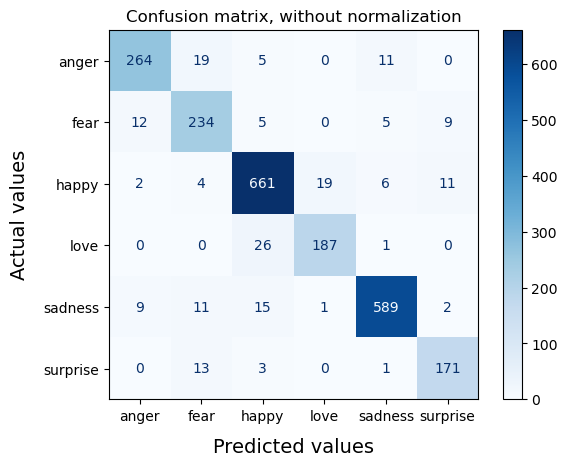

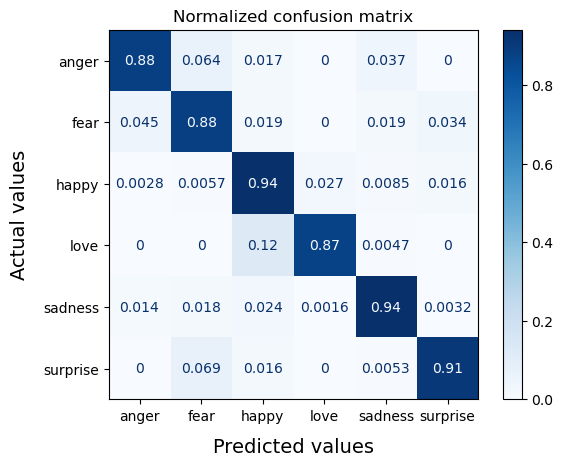

In [15]:
model_Evaluate(model, X_test, y_test)